In [41]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

data = yf.download("AAPL", start="2015-01-01", end="2025-01-30")
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

split_date = '2025-01-01'
train_data = data.loc[:split_date]
test_data = data.loc[split_date:]

C:\Users\prana\AppData\Local\Temp\ipykernel_7696\224020224.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2015-01-01", end="2025-01-30")
[*********************100%***********************]  1 of 1 completed


In [42]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)


In [43]:
def create_dataset(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i, 3])  # 'Close' price is at index 3
    return np.array(X), np.array(y)

# Choose time_steps (lookback window)
time_steps = 30
X_train, y_train = create_dataset(scaled_train, time_steps)

In [44]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=30,                    # Train for up to 30 epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

best_model = load_model('best_model.h5')

C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0069
Epoch 1: val_loss improved from None to 0.00052, saving model to best_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0031 - val_loss: 5.1560e-04
Epoch 2/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.1670e-04
Epoch 2: val_loss did not improve from 0.00052
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 7.8211e-04 - val_loss: 0.0013
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.7338e-04
Epoch 3: val_loss did not improve from 0.00052
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.9267e-04 - val_loss: 6.4962e-04


In [45]:
input_seq = scaled_train[-time_steps:]
predictions = []

for _ in range(18):  # Predict 500 future days
    reshaped_input = input_seq.reshape(1, time_steps, scaled_train.shape[1])
    pred = model.predict(reshaped_input, verbose=0)[0][0]

    next_input = np.append(input_seq[1:], [[0, 0, 0, pred, 0]], axis=0)
    input_seq = next_input
    predictions.append(pred)

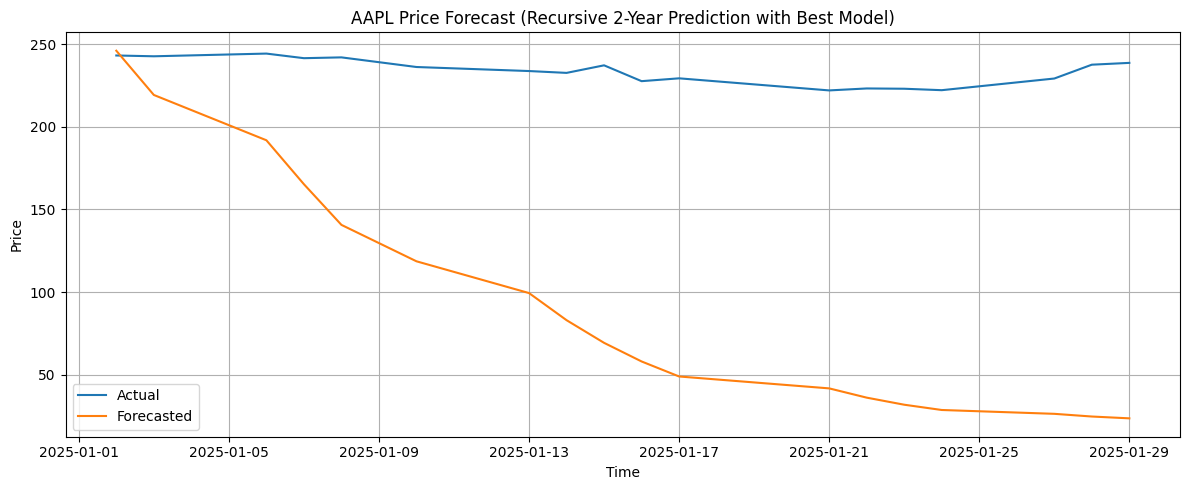

R² Score: -418.8371


In [46]:
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

# Convert predictions to NumPy array if it's a list
predictions = np.array(predictions)

# Prepare dummy array for inverse transform
pad = np.zeros((len(predictions), 5))
pad[:, 3] = predictions.flatten()  # 'Close' is at index 3
forecasted_close = scaler.inverse_transform(pad)[:, 3]

# Compute R² score
r2 = r2_score(test_data['Close'][:len(forecasted_close)], forecasted_close)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(test_data['Close'], label="Actual")
plt.plot(test_data.index, forecasted_close, label="Forecasted")
plt.title("AAPL Price Forecast (Recursive 2-Year Prediction with Best Model)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"R² Score: {r2:.4f}")


C:\Users\prana\AppData\Local\Temp\ipykernel_7696\1485256857.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2015-01-01', end='2025-01-30')
[*********************100%***********************]  1 of 1 completed
C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0295
Epoch 1: val_loss improved from None to 0.00585, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0122 - val_loss: 0.0059
Epoch 2/30
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0032
Epoch 2: val_loss improved from 0.00585 to 0.00490, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 3/30
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0024
Epoch 3: val_loss improved from 0.00490 to 0.00450, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0022 - val_loss: 0.0045
Epoch 4/30
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0021
Epoch 4: val_loss improved from 0.00450 to 0.00303, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0017
Epoch 5: val_loss did not improve fro

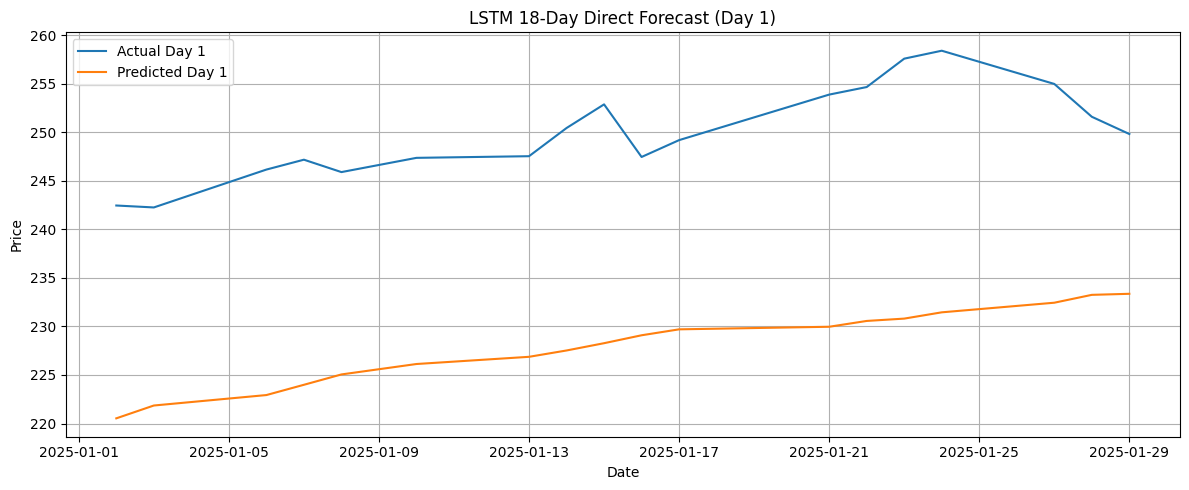

In [47]:
# === 1. Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, os, tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import yfinance as yf

# === 2. Reproducibility ===
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()

# === 3. Load and preprocess data ===
df = yf.download('AAPL', start='2015-01-01', end='2025-01-30')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)

# Normalize using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# === 4. Create supervised learning dataset ===
def create_dataset(data, time_steps, future_steps):
    X, y, dates = [], [], []
    for i in range(time_steps, len(data) - future_steps):
        X.append(data[i - time_steps:i])
        y.append([data[i + j, 3] for j in range(future_steps)])  # 'Close' price only
        dates.append(df.index[i + future_steps])
    return np.array(X), np.array(y), np.array(dates)

time_steps = 30
future_steps = 18

X, y, date_labels = create_dataset(scaled_data, time_steps, future_steps)

# === 5. Train-Test split based on date ===
split_date = pd.to_datetime("2025-01-01")
split_index = np.where(date_labels >= split_date)[0][0]

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
test_dates = date_labels[split_index:]

# === 6. Build the model ===
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(future_steps))  # Predict 18 future 'Close' prices
model.compile(optimizer='adam', loss='mean_squared_error')

# === 7. Callbacks ===
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# === 8. Train model ===
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# === 9. Load best model and predict ===
best_model = load_model('best_model.keras')
y_pred = best_model.predict(X_test)

# === 10. Rescale predictions and ground truth ===
def rescale_predictions(y_scaled, y_pred_scaled, scaler, feature_index=3):
    pad_true = np.zeros((y_scaled.size, scaler.n_features_in_))
    pad_pred = np.zeros_like(pad_true)

    for i in range(y_scaled.shape[1]):
        pad_true[i::y_scaled.shape[1], feature_index] = y_scaled[:, i]
        pad_pred[i::y_pred_scaled.shape[1], feature_index] = y_pred_scaled[:, i]

    true_rescaled = scaler.inverse_transform(pad_true)[:, feature_index].reshape(y_scaled.shape)
    pred_rescaled = scaler.inverse_transform(pad_pred)[:, feature_index].reshape(y_pred_scaled.shape)
    return true_rescaled, pred_rescaled

y_test_rescaled, y_pred_rescaled = rescale_predictions(y_test, y_pred, scaler)

# === 11. Evaluate for each future step ===
for i in range(future_steps):
    mse = mean_squared_error(y_test_rescaled[:, i], y_pred_rescaled[:, i])
    r2 = r2_score(y_test_rescaled[:, i], y_pred_rescaled[:, i])
    adj_r2 = 1 - ((1 - r2) * (len(y_test_rescaled[:, i]) - 1)) / (len(y_test_rescaled[:, i]) - X_test.shape[2] - 1)
    print(f"Day {i+1}: MSE={mse:.2f}, R²={r2:.4f}, Adjusted R²={adj_r2:.4f}")

# === 12. Plot predictions for a sample forecast (e.g., Day 1) ===
plt.figure(figsize=(12, 5))
plt.plot(test_dates[:len(y_test_rescaled)], y_test_rescaled[:, 0], label="Actual Day 1")
plt.plot(test_dates[:len(y_pred_rescaled)], y_pred_rescaled[:, 0], label="Predicted Day 1")
plt.title("LSTM 18-Day Direct Forecast (Day 1)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\prana\AppData\Local\Temp\ipykernel_7696\4186840956.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2015-01-01", end="2025-01-30")
[*********************100%***********************]  1 of 1 completed
C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


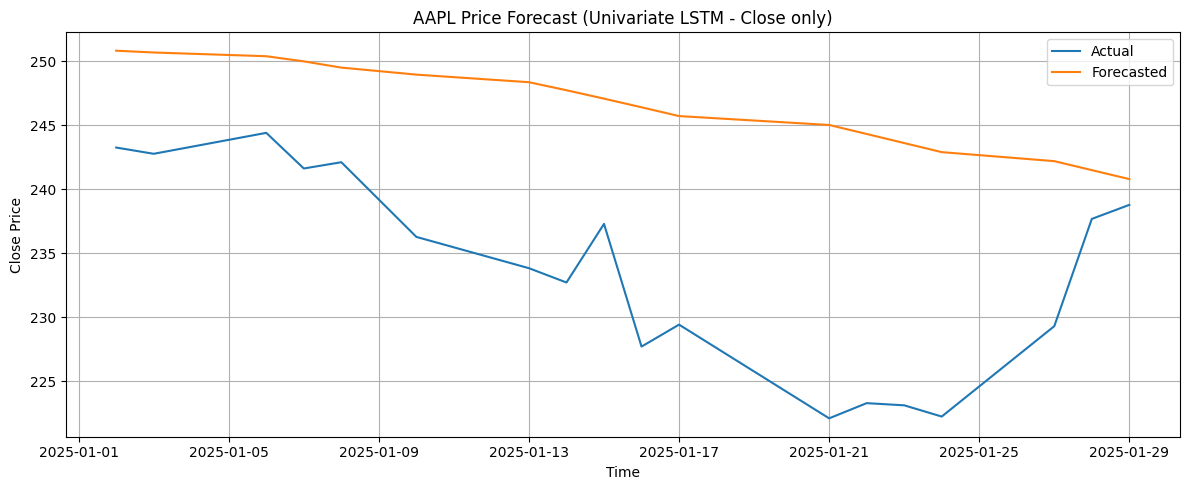

R² Score: -2.4377


In [60]:
# 📦 Imports
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import r2_score

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()
# 1. Download AAPL 'Close' price
data = yf.download("AAPL", start="2015-01-01", end="2025-01-30")
data = data[['Close']].dropna()

# 2. Train-test split
split_date = '2025-01-01'
train_data = data.loc[:split_date]
test_data = data.loc[split_date:]

# 3. Normalize using MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)

# 4. Create dataset
def create_dataset(data, time_steps=30):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# ⏱️ 5. Create sequences with time_steps
time_steps = 30
X_train, y_train = create_dataset(scaled_train, time_steps)
# 🏗️ 6. Build Univariate LSTM Model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

                    # Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

                    # Train model
model.fit(X_train, y_train,
                              epochs=10,
                              batch_size=16,
                              validation_split=0.2,
                              callbacks=[early_stop],
                              verbose=0)

                    # Recursive Forecast: Predict next 18 steps
input_seq = scaled_train[-time_steps:]
predictions = []
for _ in range(18):
    reshaped_input = input_seq.reshape(1, time_steps, 1)
    pred = model.predict(reshaped_input, verbose=0)[0][0]
    input_seq = np.append(input_seq[1:], [[pred]], axis=0)
    predictions.append(pred)

                    # Rescale predictions
predictions = np.array(predictions)
pad = np.zeros((len(predictions), 1))
pad[:, 0] = predictions
forecasted_close = scaler.inverse_transform(pad)[:, 0]

                    # R² Evaluation
true_close = test_data['Close'][:len(forecasted_close)].values
r2 = r2_score(true_close, forecasted_close)

# 📈 13. Plot the forecast
plt.figure(figsize=(12, 5))
plt.plot(test_data['Close'], label="Actual")
plt.plot(test_data.index[:len(forecasted_close)], forecasted_close, label="Forecasted")
plt.title("AAPL Price Forecast (Univariate LSTM - Close only)")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🧾 14. Print R² Score
print(f"R² Score: {r2:.4f}")


In [2]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()
# 1. Download AAPL 'Close' price
data = yf.download("AAPL", start="2015-01-01", end="2025-01-30")
data = data[['Close']].dropna()

# 2. Train-test split
split_date = '2025-01-01'
train_data = data.loc[:split_date]
test_data = data.loc[split_date:]

# 3. Normalize using MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)

# 4. Create dataset
def create_dataset(data, time_steps=30):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# 5. Grid Search Parameters
param_grid = {
    'time_steps': [5,30],
    'lstm_units': [64, 128],
    'dropout': [0.2, 0.3],
    'epochs': [10, 30],
    'batch_size': [16, 32]
}

results = []

# 6. Grid Search Loop
for time_steps in param_grid['time_steps']:
    X_train, y_train = create_dataset(scaled_train, time_steps)

    for lstm_units in param_grid['lstm_units']:
        for dropout in param_grid['dropout']:
            for epochs in param_grid['epochs']:
                for batch_size in param_grid['batch_size']:

                    # Build model
                    model = Sequential()
                    model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2])))
                    model.add(Dropout(dropout))
                    model.add(Dense(1))
                    model.compile(optimizer='adam', loss='mean_squared_error')

                    # Callbacks
                    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

                    # Train model
                    model.fit(X_train, y_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_split=0.2,
                              callbacks=[early_stop],
                              verbose=0)

                    # Recursive Forecast: Predict next 18 steps
                    input_seq = scaled_train[-time_steps:]
                    predictions = []
                    for _ in range(18):
                        reshaped_input = input_seq.reshape(1, time_steps, 1)
                        pred = model.predict(reshaped_input, verbose=0)[0][0]
                        input_seq = np.append(input_seq[1:], [[pred]], axis=0)
                        predictions.append(pred)

                    # Rescale predictions
                    predictions = np.array(predictions)
                    pad = np.zeros((len(predictions), 1))
                    pad[:, 0] = predictions
                    forecasted_close = scaler.inverse_transform(pad)[:, 0]

                    # R² Evaluation
                    true_close = test_data['Close'][:len(forecasted_close)].values
                    r2 = r2_score(true_close, forecasted_close)

                    results.append({
                        'time_steps': time_steps,
                        'units': lstm_units,
                        'dropout': dropout,
                        'epochs': epochs,
                        'batch_size': batch_size,
                        'r2_score': r2
                    })

                    print(f"✅ Tried: steps={time_steps}, units={lstm_units}, dropout={dropout}, "
                          f"epochs={epochs}, batch={batch_size}, R²={r2:.4f}")

# 7. Best Result
results_df = pd.DataFrame(results)
best_config = results_df.sort_values(by='r2_score', ascending=False).iloc[0]

print("\n🏆 Best Configuration Found:")
print(best_config)


C:\Users\prana\AppData\Local\Temp\ipykernel_4940\3069689043.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2015-01-01", end="2025-01-30")
[*********************100%***********************]  1 of 1 completed
C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=64, dropout=0.2, epochs=10, batch=16, R²=-3.2549


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=64, dropout=0.2, epochs=10, batch=32, R²=-7.5266


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=64, dropout=0.2, epochs=30, batch=16, R²=-60.8956


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=64, dropout=0.2, epochs=30, batch=32, R²=-30.2344


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=64, dropout=0.3, epochs=10, batch=16, R²=-49.1105


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=64, dropout=0.3, epochs=10, batch=32, R²=-35.2977


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=64, dropout=0.3, epochs=30, batch=16, R²=-7.2567


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=64, dropout=0.3, epochs=30, batch=32, R²=-14.5865


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=128, dropout=0.2, epochs=10, batch=16, R²=-18.2031


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=128, dropout=0.2, epochs=10, batch=32, R²=-11.3810


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=128, dropout=0.2, epochs=30, batch=16, R²=-3.3877


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=128, dropout=0.2, epochs=30, batch=32, R²=-42.3360


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=128, dropout=0.3, epochs=10, batch=16, R²=-9.1389


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=128, dropout=0.3, epochs=10, batch=32, R²=-16.9508


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=128, dropout=0.3, epochs=30, batch=16, R²=-1.8316


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units=128, dropout=0.3, epochs=30, batch=32, R²=-17.2988


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=64, dropout=0.2, epochs=10, batch=16, R²=0.3344


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=64, dropout=0.2, epochs=10, batch=32, R²=-1.8975


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=64, dropout=0.2, epochs=30, batch=16, R²=-10.1768


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=64, dropout=0.2, epochs=30, batch=32, R²=-4.5177


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=64, dropout=0.3, epochs=10, batch=16, R²=-15.4147


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=64, dropout=0.3, epochs=10, batch=32, R²=-4.2678


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=64, dropout=0.3, epochs=30, batch=16, R²=-13.0145


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=64, dropout=0.3, epochs=30, batch=32, R²=-8.1973


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=128, dropout=0.2, epochs=10, batch=16, R²=-6.6505


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=128, dropout=0.2, epochs=10, batch=32, R²=-3.2300


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=128, dropout=0.2, epochs=30, batch=16, R²=-0.4839


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=128, dropout=0.2, epochs=30, batch=32, R²=-7.6258


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=128, dropout=0.3, epochs=10, batch=16, R²=-6.2966


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=128, dropout=0.3, epochs=10, batch=32, R²=-14.5870


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=128, dropout=0.3, epochs=30, batch=16, R²=0.0053


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=128, dropout=0.3, epochs=30, batch=32, R²=-3.6150

🏆 Best Configuration Found:
time_steps    30.000000
units         64.000000
dropout        0.200000
epochs        10.000000
batch_size    16.000000
r2_score       0.334389
Name: 16, dtype: float64


Epoch 1/10


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0061 - val_loss: 0.0011
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 9.3797e-04 - val_loss: 8.3656e-04
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 8.0920e-04 - val_loss: 0.0011
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 7.0876e-04 - val_loss: 0.0018


C:\Users\prana\AppData\Local\Temp\ipykernel_4940\3703178528.py:51: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


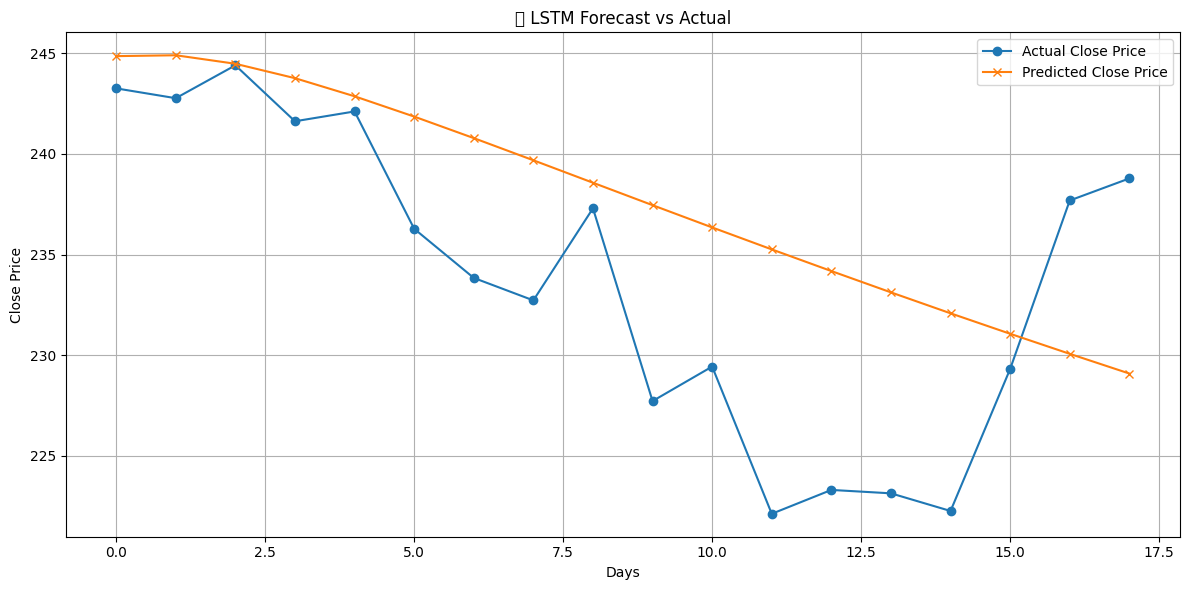


📊 Final R² Score on Test Data with Best Config: 0.1107


In [3]:
# 8. Retrain using Best Configuration
best_time_steps = best_config['time_steps']
best_units = best_config['units']
best_dropout = best_config['dropout']
best_epochs = best_config['epochs']
best_batch_size = best_config['batch_size']

# Prepare training data
X_train, y_train = create_dataset(scaled_train, int(best_time_steps))

# Build best model
best_model = Sequential()
best_model.add(LSTM(int(best_units), input_shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(Dropout(float(best_dropout)))
best_model.add(Dense(1))
best_model.compile(optimizer='adam', loss='mean_squared_error')

# Train best model
best_model.fit(X_train, y_train,
               epochs=int(best_epochs),
               batch_size=int(best_batch_size),
               validation_split=0.2,
               callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
               verbose=1)

# Recursive forecast
input_seq = scaled_train[-int(best_time_steps):]
predictions = []
for _ in range(18):
    reshaped_input = input_seq.reshape(1, int(best_time_steps), 1)
    pred = best_model.predict(reshaped_input, verbose=0)[0][0]
    input_seq = np.append(input_seq[1:], [[pred]], axis=0)
    predictions.append(pred)

# Rescale predictions
predictions = np.array(predictions).reshape(-1, 1)
forecasted_close = scaler.inverse_transform(predictions).flatten()

# Actual values for comparison
true_close = test_data['Close'][:len(forecasted_close)].values

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(true_close, label='Actual Close Price', marker='o')
plt.plot(forecasted_close, label='Predicted Close Price', marker='x')
plt.title("📈 LSTM Forecast vs Actual")
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Print R² Score again
final_r2 = r2_score(true_close, forecasted_close)
print(f"\n📊 Final R² Score on Test Data with Best Config: {final_r2:.4f}")


In [7]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()
# 1. Download AAPL 'Close' price
data = yf.download("AAPL", start="2015-01-01", end="2025-01-30")
data = data[['Close']].dropna()

# 2. Train-test split
split_date = '2025-01-01'
train_data = data.loc[:split_date]
test_data = data.loc[split_date:]

# 3. Normalize using MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)

# 4. Create dataset
def create_dataset(data, time_steps=30):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# 5. Grid Search Parameters
param_grid = {
    'time_steps': [5,30],
    'lstm_units1': [64, 128],
    'lstm_units2': [32,64],
    'dropout1': [0],
    'dropout2': [0],
    'epochs': [10, 30],
    'batch_size': [16, 32]
}

results = []

# 6. Grid Search Loop
for time_steps in param_grid['time_steps']:
    X_train, y_train = create_dataset(scaled_train, time_steps)

    for units1 in param_grid['lstm_units1']:
        for units2 in param_grid['lstm_units2']:
            for drop1 in param_grid['dropout1']:
                for drop2 in param_grid['dropout2']:
                    for epochs in param_grid['epochs']:
                        for batch_size in param_grid['batch_size']:

                    # Build model
                            model = Sequential()
                            model.add(LSTM(units1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
                            model.add(Dropout(drop1))
                            model.add(LSTM(units2))  # Second LSTM layer
                            model.add(Dropout(drop2))
                            model.add(Dense(1))
                            model.compile(optimizer='adam', loss='mean_squared_error')


                    # Callbacks
                            early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

                    # Train model
                            model.fit(X_train, y_train,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_split=0.2,
                                    callbacks=[early_stop],
                                    verbose=0)

                    # Recursive Forecast: Predict next 18 steps
                            input_seq = scaled_train[-time_steps:]
                            predictions = []
                            for _ in range(18):
                                reshaped_input = input_seq.reshape(1, time_steps, 1)
                                pred = model.predict(reshaped_input, verbose=0)[0][0]
                                input_seq = np.append(input_seq[1:], [[pred]], axis=0)
                                predictions.append(pred)

                    # Rescale predictions
                            predictions = np.array(predictions)
                            pad = np.zeros((len(predictions), 1))
                            pad[:, 0] = predictions
                            forecasted_close = scaler.inverse_transform(pad)[:, 0]

                    # R² Evaluation
                            true_close = test_data['Close'][:len(forecasted_close)].values
                            r2 = r2_score(true_close, forecasted_close)

                            results.append({
                                'time_steps': time_steps,
                                'units1': units1,
                                'units2': units2,
                                'dropout1': drop1,
                                'dropout2': drop2,
                                'epochs': epochs,
                                'batch_size': batch_size,
                                'r2_score': r2
                            })

                            print(f"✅ Tried: steps={time_steps}, units1={units1},units2={units2},dropout2={drop2}, dropout1={drop1}, "
                            f"epochs={epochs}, batch={batch_size}, R²={r2:.4f}")

# 7. Best Result
results_df = pd.DataFrame(results)
best_config = results_df.sort_values(by='r2_score', ascending=False).iloc[0]

print("\n🏆 Best Configuration Found:")
print(best_config)


C:\Users\prana\AppData\Local\Temp\ipykernel_4940\2239389382.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2015-01-01", end="2025-01-30")
[*********************100%***********************]  1 of 1 completed
C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0, dropout1=0, epochs=10, batch=16, R²=-1.1498


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0, dropout1=0, epochs=10, batch=32, R²=0.0752


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0, dropout1=0, epochs=30, batch=16, R²=-1.9694


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0, dropout1=0, epochs=30, batch=32, R²=-0.7753


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0, dropout1=0, epochs=10, batch=16, R²=-1.8178


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0, dropout1=0, epochs=10, batch=32, R²=-2.3944


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0, dropout1=0, epochs=30, batch=16, R²=-1.3239


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0, dropout1=0, epochs=30, batch=32, R²=-0.4636


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0, dropout1=0, epochs=10, batch=16, R²=-9.9713


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0, dropout1=0, epochs=10, batch=32, R²=-49.9341


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0, dropout1=0, epochs=30, batch=16, R²=0.0073


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0, dropout1=0, epochs=30, batch=32, R²=-54.9394


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0, dropout1=0, epochs=10, batch=16, R²=-6.4936


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0, dropout1=0, epochs=10, batch=32, R²=-45.0902


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0, dropout1=0, epochs=30, batch=16, R²=-7.2294


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0, dropout1=0, epochs=30, batch=32, R²=-48.3528


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0, dropout1=0, epochs=10, batch=16, R²=0.0646


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0, dropout1=0, epochs=10, batch=32, R²=0.2600


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0, dropout1=0, epochs=30, batch=16, R²=-1.5084


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0, dropout1=0, epochs=30, batch=32, R²=-2.2302


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0, dropout1=0, epochs=10, batch=16, R²=-1.5286


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0, dropout1=0, epochs=10, batch=32, R²=-1.9592


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0, dropout1=0, epochs=30, batch=16, R²=-0.3116


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0, dropout1=0, epochs=30, batch=32, R²=-0.4623


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0, dropout1=0, epochs=10, batch=16, R²=-0.9314


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0, dropout1=0, epochs=10, batch=32, R²=0.4029


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0, dropout1=0, epochs=30, batch=16, R²=-0.3149


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0, dropout1=0, epochs=30, batch=32, R²=0.4127


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0, dropout1=0, epochs=10, batch=16, R²=-1.8668


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0, dropout1=0, epochs=10, batch=32, R²=0.0890


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0, dropout1=0, epochs=30, batch=16, R²=-0.0156


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0, dropout1=0, epochs=30, batch=32, R²=-0.7466

🏆 Best Configuration Found:
time_steps     30.000000
units1        128.000000
units2         32.000000
dropout1        0.000000
dropout2        0.000000
epochs         30.000000
batch_size     32.000000
r2_score        0.412714
Name: 27, dtype: float64


In [6]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()
# 1. Download AAPL 'Close' price
data = yf.download("AAPL", start="2015-01-01", end="2025-01-30")
data = data[['Close']].dropna()

# 2. Train-test split
split_date = '2025-01-01'
train_data = data.loc[:split_date]
test_data = data.loc[split_date:]

# 3. Normalize using MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)

# 4. Create dataset
def create_dataset(data, time_steps=30):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# 5. Grid Search Parameters
param_grid = {
    'time_steps': [5,30],
    'lstm_units1': [64, 128],
    'lstm_units2': [32,64],
    'dropout1': [0.2, 0.3],
    'dropout2': [0.1, 0.2],
    'epochs': [10, 30],
    'batch_size': [16, 32]
}

results = []

# 6. Grid Search Loop
for time_steps in param_grid['time_steps']:
    X_train, y_train = create_dataset(scaled_train, time_steps)

    for units1 in param_grid['lstm_units1']:
        for units2 in param_grid['lstm_units2']:
            for drop1 in param_grid['dropout1']:
                for drop2 in param_grid['dropout2']:
                    for epochs in param_grid['epochs']:
                        for batch_size in param_grid['batch_size']:

                    # Build model
                            model = Sequential()
                            model.add(LSTM(units1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
                            model.add(Dropout(drop1))
                            model.add(LSTM(units2))  # Second LSTM layer
                            model.add(Dropout(drop2))
                            model.add(Dense(1))
                            model.compile(optimizer='adam', loss='mean_squared_error')


                    # Callbacks
                            early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

                    # Train model
                            model.fit(X_train, y_train,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_split=0.2,
                                    callbacks=[early_stop],
                                    verbose=0)

                    # Recursive Forecast: Predict next 18 steps
                            input_seq = scaled_train[-time_steps:]
                            predictions = []
                            for _ in range(18):
                                reshaped_input = input_seq.reshape(1, time_steps, 1)
                                pred = model.predict(reshaped_input, verbose=0)[0][0]
                                input_seq = np.append(input_seq[1:], [[pred]], axis=0)
                                predictions.append(pred)

                    # Rescale predictions
                            predictions = np.array(predictions)
                            pad = np.zeros((len(predictions), 1))
                            pad[:, 0] = predictions
                            forecasted_close = scaler.inverse_transform(pad)[:, 0]

                    # R² Evaluation
                            true_close = test_data['Close'][:len(forecasted_close)].values
                            r2 = r2_score(true_close, forecasted_close)

                            results.append({
                                'time_steps': time_steps,
                                'units1': units1,
                                'units2': units2,
                                'dropout1': drop1,
                                'dropout2': drop2,
                                'epochs': epochs,
                                'batch_size': batch_size,
                                'r2_score': r2
                            })

                            print(f"✅ Tried: steps={time_steps}, units1={units1},units2={units2},dropout2={drop2}, dropout1={drop1}, "
                            f"epochs={epochs}, batch={batch_size}, R²={r2:.4f}")

# 7. Best Result
results_df = pd.DataFrame(results)
best_config = results_df.sort_values(by='r2_score', ascending=False).iloc[0]

print("\n🏆 Best Configuration Found:")
print(best_config)


C:\Users\prana\AppData\Local\Temp\ipykernel_4940\1526754250.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2015-01-01", end="2025-01-30")
[*********************100%***********************]  1 of 1 completed
C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.1, dropout1=0.2, epochs=10, batch=16, R²=-0.0162


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.1, dropout1=0.2, epochs=10, batch=32, R²=-4.0484


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.1, dropout1=0.2, epochs=30, batch=16, R²=-49.6129


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.1, dropout1=0.2, epochs=30, batch=32, R²=-0.5429


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.2, dropout1=0.2, epochs=10, batch=16, R²=-0.5191


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.2, dropout1=0.2, epochs=10, batch=32, R²=-116.1973


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.2, dropout1=0.2, epochs=30, batch=16, R²=-12.8943


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.2, dropout1=0.2, epochs=30, batch=32, R²=-12.8553


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.1, dropout1=0.3, epochs=10, batch=16, R²=-2.5685


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.1, dropout1=0.3, epochs=10, batch=32, R²=-1.4533


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.1, dropout1=0.3, epochs=30, batch=16, R²=-4.0722


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.1, dropout1=0.3, epochs=30, batch=32, R²=-88.5942


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.2, dropout1=0.3, epochs=10, batch=16, R²=-2.6919


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.2, dropout1=0.3, epochs=10, batch=32, R²=-5.0520


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.2, dropout1=0.3, epochs=30, batch=16, R²=-15.3110


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=32,dropout2=0.2, dropout1=0.3, epochs=30, batch=32, R²=-6.9108


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.1, dropout1=0.2, epochs=10, batch=16, R²=-11.1535


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.1, dropout1=0.2, epochs=10, batch=32, R²=-62.0973


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.1, dropout1=0.2, epochs=30, batch=16, R²=-15.2867


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.1, dropout1=0.2, epochs=30, batch=32, R²=-14.1161


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.2, dropout1=0.2, epochs=10, batch=16, R²=-0.2225


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.2, dropout1=0.2, epochs=10, batch=32, R²=-21.6738


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.2, dropout1=0.2, epochs=30, batch=16, R²=-25.6940


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.2, dropout1=0.2, epochs=30, batch=32, R²=-63.9850


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.1, dropout1=0.3, epochs=10, batch=16, R²=-28.1249


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.1, dropout1=0.3, epochs=10, batch=32, R²=-2.3632


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.1, dropout1=0.3, epochs=30, batch=16, R²=-23.4726


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.1, dropout1=0.3, epochs=30, batch=32, R²=-20.3057


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.2, dropout1=0.3, epochs=10, batch=16, R²=-1.8376


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.2, dropout1=0.3, epochs=10, batch=32, R²=0.3059


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.2, dropout1=0.3, epochs=30, batch=16, R²=-24.0074


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=64,units2=64,dropout2=0.2, dropout1=0.3, epochs=30, batch=32, R²=-17.8608


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.1, dropout1=0.2, epochs=10, batch=16, R²=-1.3602


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.1, dropout1=0.2, epochs=10, batch=32, R²=-27.2628


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.1, dropout1=0.2, epochs=30, batch=16, R²=-0.8947


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.1, dropout1=0.2, epochs=30, batch=32, R²=-11.1947


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.2, dropout1=0.2, epochs=10, batch=16, R²=-30.7248


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.2, dropout1=0.2, epochs=10, batch=32, R²=-13.0554


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.2, dropout1=0.2, epochs=30, batch=16, R²=-0.8931


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.2, dropout1=0.2, epochs=30, batch=32, R²=-14.0495


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.1, dropout1=0.3, epochs=10, batch=16, R²=-24.1305


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.1, dropout1=0.3, epochs=10, batch=32, R²=-5.1343


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.1, dropout1=0.3, epochs=30, batch=16, R²=-26.0567


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.1, dropout1=0.3, epochs=30, batch=32, R²=-1.5393


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.2, dropout1=0.3, epochs=10, batch=16, R²=-1.9712


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.2, dropout1=0.3, epochs=10, batch=32, R²=-12.5810


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.2, dropout1=0.3, epochs=30, batch=16, R²=-0.8468


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=32,dropout2=0.2, dropout1=0.3, epochs=30, batch=32, R²=-29.1756


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.1, dropout1=0.2, epochs=10, batch=16, R²=-2.9504


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.1, dropout1=0.2, epochs=10, batch=32, R²=-27.3290


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.1, dropout1=0.2, epochs=30, batch=16, R²=-20.5133


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.1, dropout1=0.2, epochs=30, batch=32, R²=-20.2176


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.2, dropout1=0.2, epochs=10, batch=16, R²=-70.6901


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.2, dropout1=0.2, epochs=10, batch=32, R²=-29.4537


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.2, dropout1=0.2, epochs=30, batch=16, R²=-0.1253


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.2, dropout1=0.2, epochs=30, batch=32, R²=-6.1285


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.1, dropout1=0.3, epochs=10, batch=16, R²=-6.1513


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.1, dropout1=0.3, epochs=10, batch=32, R²=-63.4310


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.1, dropout1=0.3, epochs=30, batch=16, R²=-10.5688


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.1, dropout1=0.3, epochs=30, batch=32, R²=-13.4270


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.2, dropout1=0.3, epochs=10, batch=16, R²=-2.1927


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.2, dropout1=0.3, epochs=10, batch=32, R²=-20.1750


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.2, dropout1=0.3, epochs=30, batch=16, R²=-2.6323


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=5, units1=128,units2=64,dropout2=0.2, dropout1=0.3, epochs=30, batch=32, R²=-6.6351


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.1, dropout1=0.2, epochs=10, batch=16, R²=-1.0446


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.1, dropout1=0.2, epochs=10, batch=32, R²=-1.1030


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.1, dropout1=0.2, epochs=30, batch=16, R²=0.2262


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.1, dropout1=0.2, epochs=30, batch=32, R²=-7.4147


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.2, dropout1=0.2, epochs=10, batch=16, R²=-3.5187


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.2, dropout1=0.2, epochs=10, batch=32, R²=-1.7384


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.2, dropout1=0.2, epochs=30, batch=16, R²=-0.2950


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.2, dropout1=0.2, epochs=30, batch=32, R²=-5.1364


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.1, dropout1=0.3, epochs=10, batch=16, R²=-2.2284


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.1, dropout1=0.3, epochs=10, batch=32, R²=-0.3565


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.1, dropout1=0.3, epochs=30, batch=16, R²=0.3265


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.1, dropout1=0.3, epochs=30, batch=32, R²=-0.6749


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.2, dropout1=0.3, epochs=10, batch=16, R²=0.3560


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.2, dropout1=0.3, epochs=10, batch=32, R²=0.2828


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.2, dropout1=0.3, epochs=30, batch=16, R²=-0.1230


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=32,dropout2=0.2, dropout1=0.3, epochs=30, batch=32, R²=-1.1438


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.1, dropout1=0.2, epochs=10, batch=16, R²=0.3446


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.1, dropout1=0.2, epochs=10, batch=32, R²=-2.7670


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.1, dropout1=0.2, epochs=30, batch=16, R²=-0.8842


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.1, dropout1=0.2, epochs=30, batch=32, R²=-0.2744


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.2, dropout1=0.2, epochs=10, batch=16, R²=0.0470


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.2, dropout1=0.2, epochs=10, batch=32, R²=-3.5618


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.2, dropout1=0.2, epochs=30, batch=16, R²=0.1710


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.2, dropout1=0.2, epochs=30, batch=32, R²=-0.2712


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.1, dropout1=0.3, epochs=10, batch=16, R²=-2.2980


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.1, dropout1=0.3, epochs=10, batch=32, R²=-2.9412


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.1, dropout1=0.3, epochs=30, batch=16, R²=-0.1353


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.1, dropout1=0.3, epochs=30, batch=32, R²=-0.7417


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.2, dropout1=0.3, epochs=10, batch=16, R²=-0.3392


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.2, dropout1=0.3, epochs=10, batch=32, R²=-4.7633


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.2, dropout1=0.3, epochs=30, batch=16, R²=0.3986


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=64,units2=64,dropout2=0.2, dropout1=0.3, epochs=30, batch=32, R²=-0.6034


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.1, dropout1=0.2, epochs=10, batch=16, R²=0.3866


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.1, dropout1=0.2, epochs=10, batch=32, R²=-1.6145


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.1, dropout1=0.2, epochs=30, batch=16, R²=-1.5475


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.1, dropout1=0.2, epochs=30, batch=32, R²=-0.3781


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.2, dropout1=0.2, epochs=10, batch=16, R²=0.4068


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.2, dropout1=0.2, epochs=10, batch=32, R²=-0.4529


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.2, dropout1=0.2, epochs=30, batch=16, R²=-1.7517


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.2, dropout1=0.2, epochs=30, batch=32, R²=-3.7299


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.1, dropout1=0.3, epochs=10, batch=16, R²=0.3608


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.1, dropout1=0.3, epochs=10, batch=32, R²=0.3598


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.1, dropout1=0.3, epochs=30, batch=16, R²=0.0287


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.1, dropout1=0.3, epochs=30, batch=32, R²=-0.3597


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.2, dropout1=0.3, epochs=10, batch=16, R²=-0.4133


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.2, dropout1=0.3, epochs=10, batch=32, R²=-1.6764


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.2, dropout1=0.3, epochs=30, batch=16, R²=0.3778


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=32,dropout2=0.2, dropout1=0.3, epochs=30, batch=32, R²=0.3008


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.1, dropout1=0.2, epochs=10, batch=16, R²=-0.2872


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.1, dropout1=0.2, epochs=10, batch=32, R²=-1.2561


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.1, dropout1=0.2, epochs=30, batch=16, R²=-5.4078


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.1, dropout1=0.2, epochs=30, batch=32, R²=-1.3502


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.2, dropout1=0.2, epochs=10, batch=16, R²=-0.4217


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.2, dropout1=0.2, epochs=10, batch=32, R²=0.1584


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.2, dropout1=0.2, epochs=30, batch=16, R²=0.3404


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.2, dropout1=0.2, epochs=30, batch=32, R²=-0.6889


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.1, dropout1=0.3, epochs=10, batch=16, R²=0.1027


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.1, dropout1=0.3, epochs=10, batch=32, R²=-0.9615


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.1, dropout1=0.3, epochs=30, batch=16, R²=0.2819


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.1, dropout1=0.3, epochs=30, batch=32, R²=-0.9506


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.2, dropout1=0.3, epochs=10, batch=16, R²=0.3909


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.2, dropout1=0.3, epochs=10, batch=32, R²=-0.4712


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.2, dropout1=0.3, epochs=30, batch=16, R²=0.1182


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units1=128,units2=64,dropout2=0.2, dropout1=0.3, epochs=30, batch=32, R²=-1.9005

🏆 Best Configuration Found:
time_steps     30.000000
units1        128.000000
units2         32.000000
dropout1        0.200000
dropout2        0.200000
epochs         10.000000
batch_size     16.000000
r2_score        0.406753
Name: 100, dtype: float64


In [5]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()

# 1. Download AAPL 'Close' price
data = yf.download("AAPL", start="2015-01-01", end="2025-01-30")
data = data[['Close']].dropna()

# 2. Train-test split
split_date = '2025-01-01'
train_data = data.loc[:split_date]
test_data = data.loc[split_date:]

# 3. Normalize using MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)

# 4. Create dataset
def create_dataset(data, time_steps=30):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# 5. Grid Search Parameters
param_grid = {
    'time_steps': [30,60],
    'lstm_units1': [64,128],
    'lstm_units2': [64,128],
    'lstm_units3': [32,64,128],  # New third layer
    'dropout1': [0.2,0.3],
    'dropout2': [0.2,0.3],
    'dropout3': [0.2,0.3],     # New dropout
    'epochs': [10,30],
    'batch_size': [16]
}

results = []

# 6. Grid Search Loop
for time_steps in param_grid['time_steps']:
    X_train, y_train = create_dataset(scaled_train, time_steps)

    for units1 in param_grid['lstm_units1']:
        for units2 in param_grid['lstm_units2']:
            for units3 in param_grid['lstm_units3']:
                for drop1 in param_grid['dropout1']:
                    for drop2 in param_grid['dropout2']:
                        for drop3 in param_grid['dropout3']:
                            for epochs in param_grid['epochs']:
                                for batch_size in param_grid['batch_size']:

                                    # Build model
                                    model = Sequential()
                                    model.add(LSTM(units1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
                                    model.add(Dropout(drop1))

                                    model.add(LSTM(units2, return_sequences=True))
                                    model.add(Dropout(drop2))

                                    model.add(LSTM(units3))  # Last LSTM
                                    model.add(Dropout(drop3))

                                    model.add(Dense(1))
                                    model.compile(optimizer='adam', loss='mean_squared_error')

                                    # Callbacks
                                    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

                                    # Train model
                                    model.fit(X_train, y_train,
                                              epochs=epochs,
                                              batch_size=batch_size,
                                              validation_split=0.2,
                                              callbacks=[early_stop],
                                              verbose=0)

                                    # Predict next 18 steps
                                    input_seq = scaled_train[-time_steps:]
                                    predictions = []
                                    for _ in range(18):
                                        reshaped_input = input_seq.reshape(1, time_steps, 1)
                                        pred = model.predict(reshaped_input, verbose=0)[0][0]
                                        input_seq = np.append(input_seq[1:], [[pred]], axis=0)
                                        predictions.append(pred)

                                    # Rescale predictions
                                    predictions = np.array(predictions)
                                    pad = np.zeros((len(predictions), 1))
                                    pad[:, 0] = predictions
                                    forecasted_close = scaler.inverse_transform(pad)[:, 0]

                                    # R² Evaluation
                                    true_close = test_data['Close'][:len(forecasted_close)].values
                                    r2 = r2_score(true_close, forecasted_close)

                                    results.append({
                                        'time_steps': time_steps,
                                        'units1': units1,
                                        'units2': units2,
                                        'units3': units3,
                                        'dropout1': drop1,
                                        'dropout2': drop2,
                                        'dropout3': drop3,
                                        'epochs': epochs,
                                        'batch_size': batch_size,
                                        'r2_score': r2
                                    })

                                    print(f"✅ Tried: steps={time_steps}, units=({units1},{units2},{units3}), "
                                          f"dropouts=({drop1},{drop2},{drop3}), epochs={epochs}, "
                                          f"batch={batch_size}, R²={r2:.4f}")

# 7. Best Result
results_df = pd.DataFrame(results)
best_config = results_df.sort_values(by='r2_score', ascending=False).iloc[0]

print("\n🏆 Best Configuration Found:")
print(best_config)


C:\Users\prana\AppData\Local\Temp\ipykernel_70800\684810884.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2015-01-01", end="2025-01-30")
[*********************100%***********************]  1 of 1 completed
C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.2,0.2,0.2), epochs=10, batch=16, R²=-1.8698


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.2,0.2,0.2), epochs=30, batch=16, R²=0.2943


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.2,0.2,0.3), epochs=10, batch=16, R²=-0.7956


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.2,0.2,0.3), epochs=30, batch=16, R²=-1.3839


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.2,0.3,0.2), epochs=10, batch=16, R²=-0.0255


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.2,0.3,0.2), epochs=30, batch=16, R²=-0.9684


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.2,0.3,0.3), epochs=10, batch=16, R²=-2.6157


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.2,0.3,0.3), epochs=30, batch=16, R²=0.3284


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.3,0.2,0.2), epochs=10, batch=16, R²=-7.1461


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.3,0.2,0.2), epochs=30, batch=16, R²=-0.6481


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.3,0.2,0.3), epochs=10, batch=16, R²=-3.4218


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.3,0.2,0.3), epochs=30, batch=16, R²=-0.0871


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.3,0.3,0.2), epochs=10, batch=16, R²=-1.1918


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.3,0.3,0.2), epochs=30, batch=16, R²=-4.9937


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.3,0.3,0.3), epochs=10, batch=16, R²=0.1314


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,32), dropouts=(0.3,0.3,0.3), epochs=30, batch=16, R²=-6.9680


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.2,0.2,0.2), epochs=10, batch=16, R²=-1.5070


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.2,0.2,0.2), epochs=30, batch=16, R²=-5.6567


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.2,0.2,0.3), epochs=10, batch=16, R²=-2.1395


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.2,0.2,0.3), epochs=30, batch=16, R²=0.3993


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.2,0.3,0.2), epochs=10, batch=16, R²=-1.0466


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.2,0.3,0.2), epochs=30, batch=16, R²=-4.3423


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.2,0.3,0.3), epochs=10, batch=16, R²=-0.0137


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.2,0.3,0.3), epochs=30, batch=16, R²=0.2806


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.3,0.2,0.2), epochs=10, batch=16, R²=0.0597


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.3,0.2,0.2), epochs=30, batch=16, R²=0.2320


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.3,0.2,0.3), epochs=10, batch=16, R²=-0.2598


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.3,0.2,0.3), epochs=30, batch=16, R²=-5.6734


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.3,0.3,0.2), epochs=10, batch=16, R²=-0.4631


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.3,0.3,0.2), epochs=30, batch=16, R²=0.2273


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.3,0.3,0.3), epochs=10, batch=16, R²=0.3038


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,64), dropouts=(0.3,0.3,0.3), epochs=30, batch=16, R²=0.3942


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.2,0.2,0.2), epochs=10, batch=16, R²=0.3280


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.2,0.2,0.2), epochs=30, batch=16, R²=-0.5135


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.2,0.2,0.3), epochs=10, batch=16, R²=-3.9587


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.2,0.2,0.3), epochs=30, batch=16, R²=-3.2988


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.2,0.3,0.2), epochs=10, batch=16, R²=0.1176


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.2,0.3,0.2), epochs=30, batch=16, R²=0.0674


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.2,0.3,0.3), epochs=10, batch=16, R²=0.2721


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.2,0.3,0.3), epochs=30, batch=16, R²=-0.0970


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.3,0.2,0.2), epochs=10, batch=16, R²=0.0193


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.3,0.2,0.2), epochs=30, batch=16, R²=0.3156


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.3,0.2,0.3), epochs=10, batch=16, R²=-0.1964


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.3,0.2,0.3), epochs=30, batch=16, R²=-3.7791


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.3,0.3,0.2), epochs=10, batch=16, R²=0.3292


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.3,0.3,0.2), epochs=30, batch=16, R²=0.3345


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.3,0.3,0.3), epochs=10, batch=16, R²=0.2154


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,64,128), dropouts=(0.3,0.3,0.3), epochs=30, batch=16, R²=0.0141


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.2,0.2,0.2), epochs=10, batch=16, R²=-0.2310


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.2,0.2,0.2), epochs=30, batch=16, R²=-16.4467


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.2,0.2,0.3), epochs=10, batch=16, R²=-2.9535


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.2,0.2,0.3), epochs=30, batch=16, R²=0.1750


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.2,0.3,0.2), epochs=10, batch=16, R²=-0.8393


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.2,0.3,0.2), epochs=30, batch=16, R²=-2.1833


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.2,0.3,0.3), epochs=10, batch=16, R²=0.2314


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.2,0.3,0.3), epochs=30, batch=16, R²=-12.9412


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.3,0.2,0.2), epochs=10, batch=16, R²=0.2718


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.3,0.2,0.2), epochs=30, batch=16, R²=-0.3033


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.3,0.2,0.3), epochs=10, batch=16, R²=-1.0209


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.3,0.2,0.3), epochs=30, batch=16, R²=-1.7112


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.3,0.3,0.2), epochs=10, batch=16, R²=0.3216


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.3,0.3,0.2), epochs=30, batch=16, R²=-0.9920


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.3,0.3,0.3), epochs=10, batch=16, R²=-0.0234


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Tried: steps=30, units=(64,128,32), dropouts=(0.3,0.3,0.3), epochs=30, batch=16, R²=0.0001


C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [62]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()
# 1. Download AAPL 'Close' price
data = yf.download("AAPL", start="2015-01-01", end="2025-01-30")
data = data[['Close']].dropna()

# 2. Train-test split
split_date = '2025-01-01'
train_data = data.loc[:split_date]
test_data = data.loc[split_date:]

# 3. Normalize using MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)

# 4. Create dataset
def create_dataset(data, time_steps=30):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)
def rescale_predictions(y_scaled, y_pred_scaled, scaler, feature_index=3):
    pad_true = np.zeros((y_scaled.size, scaler.n_features_in_))
    pad_pred = np.zeros_like(pad_true)

    for i in range(y_scaled.shape[1]):
        pad_true[i::y_scaled.shape[1], feature_index] = y_scaled[:, i]
        pad_pred[i::y_pred_scaled.shape[1], feature_index] = y_pred_scaled[:, i]

    true_rescaled = scaler.inverse_transform(pad_true)[:, feature_index].reshape(y_scaled.shape)
    pred_rescaled = scaler.inverse_transform(pad_pred)[:, feature_index].reshape(y_pred_scaled.shape)
    return true_rescaled, pred_rescaled


# 5. Grid Search Parameters
param_grid = {
    'time_steps': [5,30],
    'lstm_units': [64, 128],
    'dropout': [0.2, 0.3],
    'epochs': [10, 30],
    'batch_size': [16, 32]
}

results = []

# 6. Grid Search Loop
for time_steps in param_grid['time_steps']:
    X_train, y_train = create_dataset(scaled_train, time_steps)

    for lstm_units in param_grid['lstm_units']:
        for dropout in param_grid['dropout']:
            for epochs in param_grid['epochs']:
                for batch_size in param_grid['batch_size']:

                    # Build model
                    model = Sequential()
                    model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2])))
                    model.add(Dropout(dropout))
                    model.add(Dense(1))
                    model.compile(optimizer='adam', loss='mean_squared_error')

                    # Callbacks
                    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

                    # Train model
                    history = model.fit(X_train, y_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_split=0.2,
                              callbacks=[early_stop],
                              verbose=0)



                    y_pred = model.predict(X_test)


                    y_test_rescaled, y_pred_rescaled = rescale_predictions(y_test, y_pred, scaler)
                    for i in range(future_steps):
                        mse = mean_squared_error(y_test_rescaled[:, i], y_pred_rescaled[:, i])
                        r2 = r2_score(y_test_rescaled[:, i], y_pred_rescaled[:, i])
                        adj_r2 = 1 - ((1 - r2) * (len(y_test_rescaled[:, i]) - 1)) / (len(y_test_rescaled[:, i]) - X_test.shape[2] - 1)
                        print(f"Day {i+1}: MSE={mse:.2f}, R²={r2:.4f}, Adjusted R²={adj_r2:.4f}")
                    # R² Evaluation
                    true_close = test_data['Close'][:len(forecasted_close)].values
                    r2 = r2_score(true_close, forecasted_close)

                    results.append({
                        'time_steps': time_steps,
                        'units': lstm_units,
                        'dropout': dropout,
                        'epochs': epochs,
                        'batch_size': batch_size,
                        'r2_score': r2
                    })

                    print(f"✅ Tried: steps={time_steps}, units={lstm_units}, dropout={dropout}, "
                          f"epochs={epochs}, batch={batch_size}, R²={r2:.4f}")

# 7. Best Result
results_df = pd.DataFrame(results)
best_config = results_df.sort_values(by='r2_score', ascending=False).iloc[0]

print("\n🏆 Best Configuration Found:")
print(best_config)


C:\Users\prana\AppData\Local\Temp\ipykernel_7696\832059629.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2015-01-01", end="2025-01-30")
[*********************100%***********************]  1 of 1 completed
C:\Users\prana\PycharmProjects\Intern\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 5 and 1 for '{{node sequential_118_1/lstm_118_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_118_1/lstm_118_1/strided_slice_1, sequential_118_1/lstm_118_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [18,5], [1,256].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(18, 5), dtype=float32)
  • states=('tf.Tensor(shape=(18, 64), dtype=float32)', 'tf.Tensor(shape=(18, 64), dtype=float32)')
  • training=False